# Import Packages

In [1]:
from packages import *
%matplotlib inline

# Read Dataset

In [2]:
all_files = glob.glob('virufy_clean/*')
l1, l2 = [], []
for i in all_files: 
    l1.append(i)
    label = i.split('\\')[1][:3].strip()
    l2.append(label)
df = pd.DataFrame(zip(l1,l2),columns=['fname','label'])
df.head()

,fname,label
0,virufy_clean\neg-0421-083-cough-m-53-1.wav,neg
1,virufy_clean\neg-0421-083-cough-m-53-10.wav,neg
2,virufy_clean\neg-0421-083-cough-m-53-11.wav,neg
3,virufy_clean\neg-0421-083-cough-m-53-12.wav,neg
4,virufy_clean\neg-0421-083-cough-m-53-13.wav,neg


# Get class distribution

In [3]:
df.set_index('fname', inplace=True)

for f in df.index:
    signal,rate = librosa.load(f)
    df.at[f, 'length'] = signal.shape[0]/rate

df.head()

,label,length
fname,,
virufy_clean\neg-0421-083-cough-m-53-1.wav,neg,0.473469
virufy_clean\neg-0421-083-cough-m-53-10.wav,neg,0.438277
virufy_clean\neg-0421-083-cough-m-53-11.wav,neg,0.511202
virufy_clean\neg-0421-083-cough-m-53-12.wav,neg,0.462132
virufy_clean\neg-0421-083-cough-m-53-13.wav,neg,0.537914


In [4]:
# get class names
classes = list(np.unique(df.label))

# get probability distribution of classes based on duration of audio files
class_dist = df.groupby(['label'])['length'].mean()
prob_dist = class_dist/class_dist.sum()

# Get 2 * audio samples of duration 1/10 secs taken from all audio files
n_samples = int(2 * (1/0.1)* df['length'].sum())
n_samples

1494

# Feature Extraction

In [5]:
# function to load existing model configurations (if exists)
def check_data():
    if os.path.isfile(config.p_path):
        print('Loading existing data for {} model'.format(config.mode))
        with open(config.p_path,'rb') as handle:
            tmp = pickle.load(handle)
            return tmp
    else:
        return None

In [6]:
def build_random_feat():
    
    # if configurations already exit for a model, then load them. If not, then make new configurations.
    tmp = check_data()
    if tmp:
        return tmp.data[0],tmp.data[1]
    
    X = []
    y = []
    _min, _max = float('inf'), float('-inf')
    
    for _ in tqdm(range(n_samples)):
        
        # choose a random audio sample from dataset according to their probability distribution
        rand_class = np.random.choice(class_dist.index,p=prob_dist)
        file = np.random.choice(df[df.label==rand_class].index)
        rate, wav = wavfile.read(file)
        label = df.at[file,'label']
        
        # crop a random duration of 1/10 sec from chosen audio sample
        rand_index = np.random.randint(0,wav.shape[0]-config.step)
        sample = wav[rand_index:rand_index+config.step]
        
        # get MFCC of the cropped duration
        X_sample = mfcc(sample, rate,
                    numcep=config.nfeat, nfilt=config.nfilt, nfft=config.nfft)
        
        _min = min(np.amin(X_sample), _min)
        _max = max(np.amax(X_sample), _max)
        
        # save audio sample
        X.append(X_sample)
        y.append(classes.index(label))
        
    config.min = _min
    config.max = _max
    
    X, y = np.array(X), np.array(y)
    X = (X - _min) / (_max - _min)
    
    if config.mode=='conv':
        X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)
    elif config.mode=='time':
        X = X.reshape(X.shape[0], X.shape[1], X.shape[2])
        
    config.data = (X,y)
    
    # save model configurations
    with open(config.p_path,'wb') as handle:
        pickle.dump(config, handle, protocol=pickle.HIGHEST_PROTOCOL)
             
    return X,y

# Modeling

In [7]:
# Define 2DCNN model architecture

def get_conv_model():
    model = Sequential()
    model.add(Conv2D(16, (5, 5), activation='relu', strides=(2, 2),
                     padding='same', input_shape=input_shape))
    model.add(Conv2D(32, (3, 3), activation='relu', strides=(1, 1),
                     padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', strides=(1, 1),
                     padding='same'))
    model.add(MaxPool2D((2,2)))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.summary()
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['acc'])
    return model

In [9]:
# Instantiate 2DCNN model

config = Config(mode='conv')

In [10]:
if config.mode == 'conv':
    X, y = build_random_feat()
    input_shape = (X.shape[1], X.shape[2], 1)
    model = get_conv_model()
    model_name = 'MFCC_Conv2D'
    
elif config.mode == 'time':
    X, y = build_random_feat()
    input_shape = (X.shape[1], X.shape[2])
    model = get_recurrent_model()
    model_name = 'MFCC_LSTM'

Loading existing data for conv model
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 5, 7, 16)          416       
                                                                 
 conv2d_1 (Conv2D)           (None, 5, 7, 32)          4640      
                                                                 
 conv2d_2 (Conv2D)           (None, 5, 7, 64)          18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 2, 3, 64)         0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 2, 3, 64)          0         
                                                                 
 flatten (Flatten)           (None, 384)               0         
                   

In [11]:
Counter(y)

Counter({0: 652, 1: 842})

In [12]:
# class weights to handle class imbalance (if any)

class_weights = compute_class_weight(class_weight = "balanced", classes = np.unique(y), y = y)
class_weights = dict(zip(np.unique(y), class_weights))
class_weights

{0: 1.1457055214723926, 1: 0.8871733966745843}

In [13]:
# Callbacks

checkpoint      = ModelCheckpoint(config.model_path, 
                                  monitor='val_acc', 
                                  verbose=0, 
                                  save_best_only=True, 
                                  mode='max',
                                 save_weights_only=False,
                                 period=1)

csv_logger      = CSVLogger('plots/{}.csv'.format(model_name))

es = EarlyStopping(monitor='val_loss', mode='min', patience=20)  

callbacks_list  = [checkpoint,
                   csv_logger,
                   es
                  ]

In [14]:
# Train model

model.fit(X, y, 
          epochs=100, 
          batch_size=32,
          shuffle=True,
          validation_split=0.2,
          class_weight=class_weights,
          callbacks=callbacks_list)

Epoch 1/100
38/38 [==============================] - 4s 26ms/step - loss: 0.6923 - acc: 0.5464 - val_loss: 0.6864 - val_acc: 0.5351
Epoch 2/100
38/38 [==============================] - 1s 23ms/step - loss: 0.6626 - acc: 0.6059 - val_loss: 0.6010 - val_acc: 0.7023
Epoch 3/100
38/38 [==============================] - 0s 4ms/step - loss: 0.6031 - acc: 0.6820 - val_loss: 0.5931 - val_acc: 0.6756
Epoch 4/100
38/38 [==============================] - 1s 20ms/step - loss: 0.5644 - acc: 0.7205 - val_loss: 0.5295 - val_acc: 0.7625
Epoch 5/100
38/38 [==============================] - 0s 4ms/step - loss: 0.5130 - acc: 0.7506 - val_loss: 0.4978 - val_acc: 0.7492
Epoch 6/100
38/38 [==============================] - 1s 21ms/step - loss: 0.4709 - acc: 0.7791 - val_loss: 0.4297 - val_acc: 0.7993
Epoch 7/100
38/38 [==============================] - 1s 19ms/step - loss: 0.4393 - acc: 0.7883 - val_loss: 0.3718 - val_acc: 0.8562
Epoch 8/100
38/38 [==============================] - 0s 5ms/step - loss: 0.406

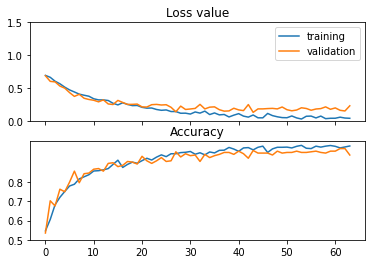

In [16]:
# Plot curves

records = pd.read_csv('plots/{}.csv'.format(model_name))
plt.figure()

plt.subplot(211)
plt.plot(records['loss'],label="training")
plt.plot(records['val_loss'], label="validation")
plt.yticks([0.00,0.50,1.00,1.50])
plt.title('Loss value',fontsize=12)

ax = plt.gca()
ax.set_xticklabels([])

plt.subplot(212)
plt.plot(records['acc'],label="training")
plt.plot(records['val_acc'],label="validation")
plt.yticks([0.5,0.6,0.7,0.8])
plt.title('Accuracy',fontsize=12)
ax.legend()
plt.show()

# Save model

In [15]:
model.save(config.model_path)

INFO:tensorflow:Assets written to: models\conv.model\assets
